In [1]:
import pandas as pd
from langdetect import detect
from deep_translator import GoogleTranslator
import re
import spacy
from underthesea import word_tokenize, pos_tag
from nltk.corpus import stopwords
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

In [2]:
nlp = spacy.load('en_core_web_md')
stop_words = set(stopwords.words('english'))

In [3]:
csv_cr = "../../data/raw/UpdatedResumeDataSet.csv"

In [4]:
df = pd.read_csv(csv_cr)

In [5]:
pd.DataFrame(df)

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
...,...,...
957,Testing,Computer Skills: â¢ Proficient in MS office (...
958,Testing,â Willingness to accept the challenges. â ...
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne..."
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...


In [6]:
df['Category'].unique()

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

In [7]:
list_job_to_remove = ['Sales','Health and fitness','PMO','Arts']

df = df[~df['Category'].isin(list_job_to_remove)]

In [8]:
df['Category'].unique()

array(['Data Science', 'HR', 'Advocate', 'Web Designing',
       'Mechanical Engineer', 'Civil Engineer', 'Java Developer',
       'Business Analyst', 'SAP Developer', 'Automation Testing',
       'Electrical Engineering', 'Operations Manager', 'Python Developer',
       'DevOps Engineer', 'Network Security Engineer', 'Database',
       'Hadoop', 'ETL Developer', 'DotNet Developer', 'Blockchain',
       'Testing'], dtype=object)

In [17]:
def read_skills(file_path):
    skills = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line and not line.startswith('#'):
                skills.append(line.lower())
    return skills
def remove_stopwords(text):
    tokens = text.split()
    cleaned = []

    for token in tokens:
        if token.isupper():
            cleaned.append(token)
            continue
        if token.lower() in stop_words :
            continue
        cleaned.append(token)
    return ' '.join(cleaned)
def clean_text(text, lang='en'):
    if not isinstance(text, str) or not text.strip():
        return ''
    text = text.lower()
    text = re.sub(r'(?<=\b\w)[-/](?=\w\b)', ' ', text)
    text = re.sub(r'\s*&\s*', ' ', text)
    text = re.sub(r'http\S+|@\s|\s@|#(?=\s)|\s#', ' ', text)
    text = re.sub(r'[()]', ' ', text)
    text = re.sub(r'(?<!\w)[.,!?;:–—](?!\w)', ' ', text)
    text = re.sub(r'[\n\r\t]', ' ', text) 
    text = re.sub(r"\b\w*['’‘]\w*\b", '', text)
    text = re.sub(r'\s*[-–—]{2,}\s*', ' ', text)
    text = re.sub(r'[“”‘’«»„‟]', ' ', text)
    text = re.sub(r'(?<=\w)[.,!:](?=\s|$)', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'/', ' ', text)
    text = re.sub(r'(?<=\w):(?=\w)', ' ', text)
    text = re.sub(r'([^a-zA-Z0-9\s])\1{2,}', '', text)

    text = remove_stopwords(text)
    return text

In [14]:
df['resume_cleaned'] = df['Resume'].apply(clean_text)

In [15]:
pd.DataFrame(df)

,Category,Resume,resume_cleaned
0,Data Science,Skills * Programming Languages: Python (pandas...,skills * programming languages python pandas n...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,education details may 2013 may 2017 b.e uit-rg...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",areas interest deep learning control system de...
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,skills â¢ r â¢ python â¢ sap hana â¢ table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",education details mca ymcaust faridabad haryan...
...,...,...,...
957,Testing,Computer Skills: â¢ Proficient in MS office (...,computer skills â¢ proficient ms office word ...
958,Testing,â Willingness to accept the challenges. â ...,â willingness accept challenges â positive...
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...",personal skills â¢ quick learner â¢ eagernes...
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...,computer skills software knowledge ms-power po...


In [18]:
primary_skills = read_skills('../../data/primary_skills.txt')
secondary_skills = read_skills('../../data/secondary_skills.txt')

In [ ]:
import re
from collections import Counter
import spacy

def clean_text_for_matching(text):
    return re.sub(r'[^a-zA-Z0-9\s]', ' ', text).lower()
# nlp_en = spacy.load("en_core_web_sm")
def normalize_skills(skills):
    return [clean_text_for_matching(skill).strip() for skill in skills]
adj_counter = Counter()
adv_counter = Counter()
normalized_primary_skills = normalize_skills(primary_skills)
normalized_secondary_skills = normalize_skills(secondary_skills)
def remove_unwanted_skills(skill_string):
    if not skill_string:
        return ''
    if pd.isna(skill_string):
        return skill_string
    skills = [s.strip() for s in skill_string.split(',')]
    filtered = [s for s in skills if s.lower() not in skills_to_remove]
    return ', '.join(filtered)




def generate_ngrams(text, max_n=3):
    tokens = text.split()
    ngrams = []
    for n in range(1, max_n+1):
        ngrams.extend([' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)])
    return ngrams

def extract_primary_skills(text):
    if not isinstance(text, str) or pd.isna(text):
        return []

    text_cleaned = clean_text_for_matching(text)
    ngrams = generate_ngrams(text_cleaned, max_n=3)

    found = [skill for skill in normalized_primary_skills if skill in ngrams]

    return list(dict.fromkeys(found))

def extract_secondary_skills(text):
    if not isinstance(text, str) or pd.isna(text):
        return []

    text_cleaned = clean_text_for_matching(text)
    ngrams = generate_ngrams(text_cleaned, max_n=3)

    primary = extract_primary_skills(text)
    secondary = [skill for skill in normalized_secondary_skills if skill in ngrams and skill not in primary]

    return list(dict.fromkeys(secondary))


def extract_adjectives(text):
    if not isinstance(text, str) or pd.isna(text):
        return []

    doc = nlp(text)
    adjs = [
        token.lemma_.lower()
        for token in doc
        if token.pos_ == "ADJ"
        and len(token.lemma_) > 2            # loại từ ngắn như "as", "own"
        and token.is_alpha                   # bỏ từ chứa số, ký hiệu
        and not token.is_stop                # loại stop words mặc định của spaCy
    ][:15]
    adj_counter.update(adjs)
    return list(set(adjs))

def extract_adverbs(text):
    if not isinstance(text, str) or pd.isna(text):
        return []

    doc = nlp(text)
    advs = [
        token.lemma_.lower()
        for token in doc
        if token.pos_ == "ADV"
        and len(token.lemma_) > 2
        and token.is_alpha
        and not token.is_stop
    ][:15]
    adv_counter.update(advs)
    return list(set(advs))

In [23]:
df['primary_skills'] = df['resume_cleaned'].apply(extract_primary_skills)
df['secondary_skills'] = df['resume_cleaned'].apply(extract_secondary_skills)
df['adjectives'] = df['resume_cleaned'].apply(extract_adjectives)
df['adverbs'] = df['resume_cleaned'].apply(extract_adverbs)

df.loc[:, 'primary_skills'] = df.apply(
    lambda row: extract_primary_skills(f"{row['resume_cleaned'] or ''}"),
    axis=1
)

df.loc[:, 'secondary_skills'] = df.apply(
    lambda row: extract_secondary_skills(f"{row['resume_cleaned'] or ''}"),
    axis=1
)

df.loc[:, 'adjectives'] = df.apply(
    lambda row: extract_adjectives(f"{row['resume_cleaned'] or ''}"),
    axis=1
)

df.loc[:, 'adverbs'] = df.apply(
    lambda row: extract_adverbs(f"{row['resume_cleaned'] or ''}"),
    axis=1
)

C:\Users\ACER ASPIRE\AppData\Local\Temp\ipykernel_19600\1403453381.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=skills_df, palette='viridis')


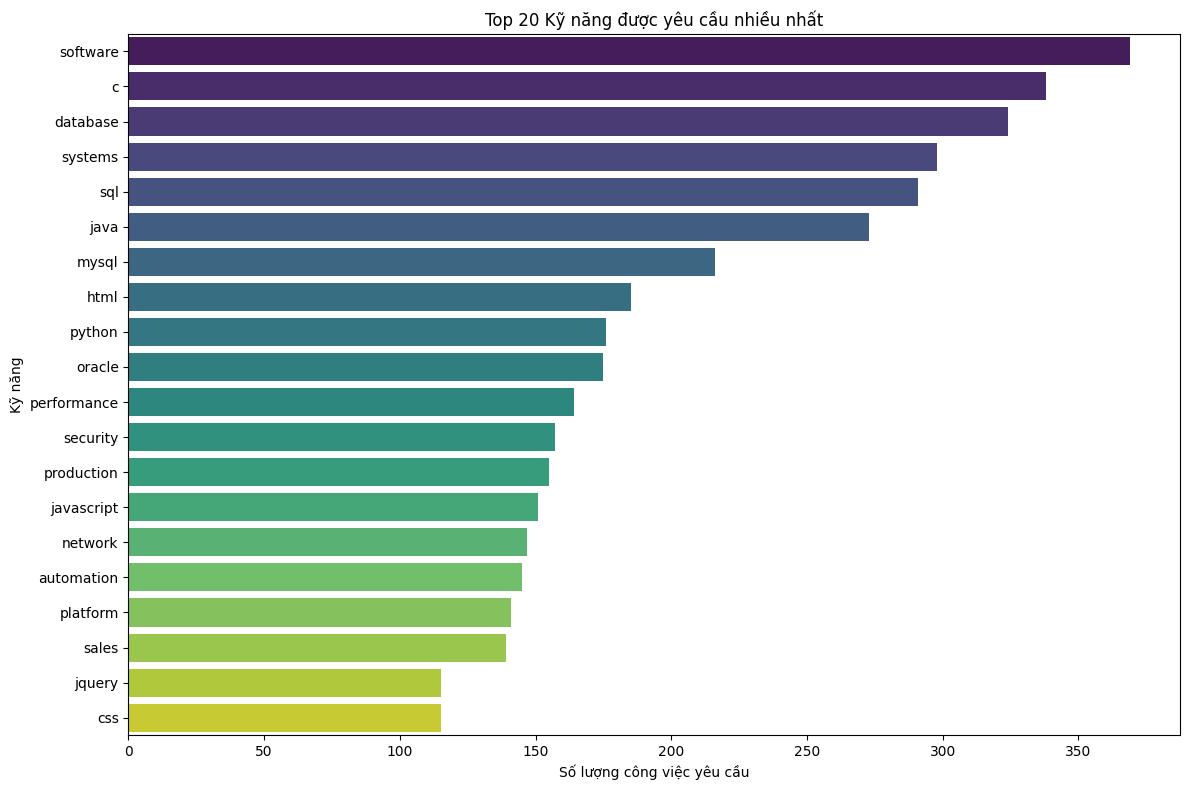

In [24]:
skills_series = df['primary_skills'].explode().dropna().str.strip()

# Đếm kỹ năng phổ biến nhất
skill_counts = Counter(skills_series)
top_skills = skill_counts.most_common(20)

# Chuyển thành DataFrame để vẽ biểu đồ
skills_df = pd.DataFrame(top_skills, columns=['Skill', 'Count'])

# Vẽ biểu đồ
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Skill', data=skills_df, palette='viridis')
plt.title('Top 20 Kỹ năng được yêu cầu nhiều nhất')
plt.xlabel('Số lượng công việc yêu cầu')
plt.ylabel('Kỹ năng')
plt.tight_layout()
plt.show()

In [25]:
for i in range(len(df)):
    df.at[i, 'id'] = "CANDIDATE_" + str(i)

In [36]:
pd.DataFrame(df)

,Category,Resume,resume_cleaned,primary_skills,secondary_skills,adjectives,adverbs,id
0,Data Science,Skills * Programming Languages: Python (pandas...,skill programming language python pandas numpy...,"[python, java, javascript, angular, flask, mys...","[git, docker, elasticsearch, logstash, kibana,...","[present, automate, inbuilt, predictive, negat...","[well, plotly, frequently, personally, also]",CANDIDATE_0
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,education detail may 2013 may 2017 b e uit rgp...,"[python, keras, machine learning, data scientist]","[git, github]","[koramangala, professional, 5th, dummy, less, ...",[mainly],CANDIDATE_1
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",area interest deep learning control system des...,"[python, java, matlab, bash, django, flask, el...","[git, github, linux, ubuntu, debian, pycharm, ...","[ide, electrical, mathematic, little, senior, ...","[back, currently, much, henceforth, basically]",CANDIDATE_2
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,skill â r â python â sap hana â tableau â sap ...,"[python, swift, electron, sql server, lstm, de...","[git, windows server, visual studio, segment]","[present, enough, close, historic, predictive,...","[successfully, manually, fast, actively, deep,...",CANDIDATE_3
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",education detail mca ymcaust faridabad haryana...,"[python, java]",[],[less],[],CANDIDATE_4
...,...,...,...,...,...,...,...,...
704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CANDIDATE_704
705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CANDIDATE_705
706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CANDIDATE_706
707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CANDIDATE_707


In [26]:
df.dropna(inplace=True)
df.to_csv('../../data/clean/clean_resumes_v2.csv', index=False, encoding='utf-8')